In [1]:
import os
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
from glob import glob
import numpy as np
import matplotlib
import seaborn as sns
import PIL
PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import sys
import json
import pandas as pd
import cvlib as cv
from cvlib.object_detection import draw_bbox
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import tensorflow_datasets as tfds
import pathlib

In [2]:
dataset_path = 'C:/Users/82106/Documents/ds_study/source_code/DL project/통제환경 부분추출'

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_x = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 23485 files belonging to 5 classes.
Using 18788 files for training.


In [5]:
val_x = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 23485 files belonging to 5 classes.
Using 4697 files for validation.


In [6]:
class_names = train_x.class_names
print(class_names)

['cigar', 'normal', 'phone', 'sleep', 'yawn']


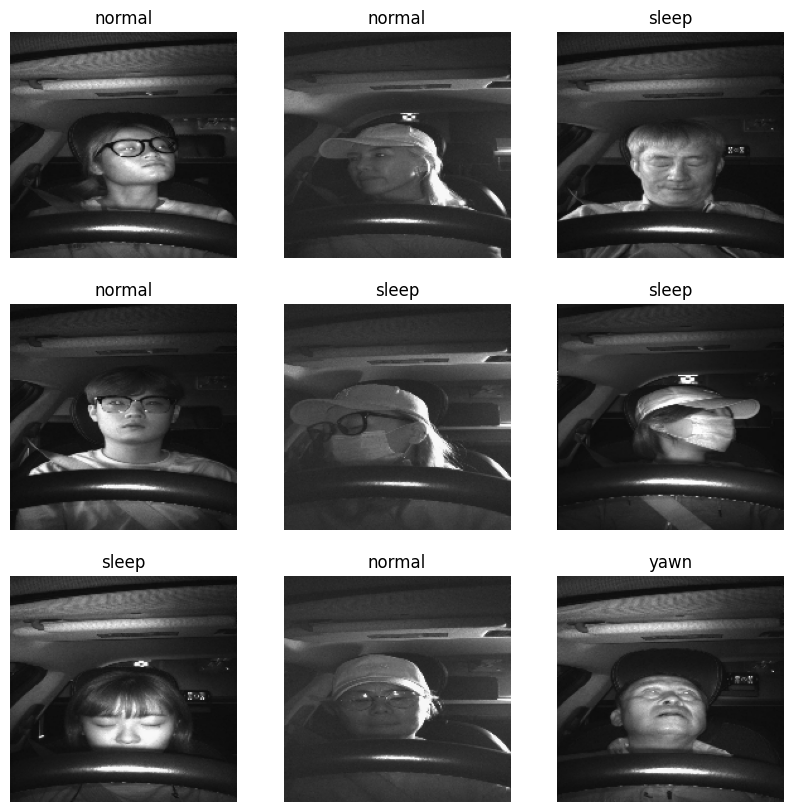

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_x.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_x:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [10]:
normalized_x = train_x.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_x))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.033004224 0.99095994


## VGGNET 사용

In [28]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax'),
  tf.keras.layers.Dense(num_classes)
])

In [29]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [31]:
hist = model.fit(
  train_x,
  validation_data=val_x,
  epochs=5
)

Epoch 1/5


TypeError: 'NoneType' object is not callable

In [ ]:
hist.history

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(hist.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(hist.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()

In [ ]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12,8))

for each in plot_target:
    plt.plot(hist.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [ ]:
score = model.evaluate(train_x)
score

## RESNET 사용

In [15]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [16]:
def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net1_1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net = Add()([net1_1, net3])

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net = Add()([net, net3])

    net = MaxPool2D()(net)

    net = Flatten()(net)
    net = Dense(10, activation='softmax')(net)

    model2 = tf.keras.Model(inputs=inputs, outputs=net)

    return model2

In [17]:
model2 = build_resnet((180,180,3))

In [18]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 90, 90, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 45, 45, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 45, 45, 64)   2112        ['max_pooling2d_2[0][0]']    

In [19]:
model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
hist2 = model2.fit(
  train_x,
  validation_data=val_x,
  epochs=5)

Epoch 1/5
588/588 [==============================] - 408s 691ms/step - loss: 4.8101 - accuracy: 0.4579 - val_loss: 1.1667 - val_accuracy: 0.5067
Epoch 2/5
588/588 [==============================] - 392s 666ms/step - loss: 1.0042 - accuracy: 0.5810 - val_loss: 1.2052 - val_accuracy: 0.5312
Epoch 3/5
588/588 [==============================] - 381s 646ms/step - loss: 0.8409 - accuracy: 0.6497 - val_loss: 1.0856 - val_accuracy: 0.5842
Epoch 4/5
588/588 [==============================] - 377s 641ms/step - loss: 0.7565 - accuracy: 0.6884 - val_loss: 1.1929 - val_accuracy: 0.5714
Epoch 5/5
588/588 [==============================] - 391s 663ms/step - loss: 0.7119 - accuracy: 0.7066 - val_loss: 1.1613 - val_accuracy: 0.5757


In [21]:
hist2.history

{'loss': [4.810124397277832,
  1.0041590929031372,
  0.8408910632133484,
  0.7565215229988098,
  0.7119122743606567],
 'accuracy': [0.45789864659309387,
  0.5810091495513916,
  0.6496700048446655,
  0.6884181499481201,
  0.7065680027008057],
 'val_loss': [1.1666637659072876,
  1.2052116394042969,
  1.085626244544983,
  1.1928790807724,
  1.1613184213638306],
 'val_accuracy': [0.5067064166069031,
  0.5311900973320007,
  0.5842027068138123,
  0.5714285969734192,
  0.5756866335868835]}

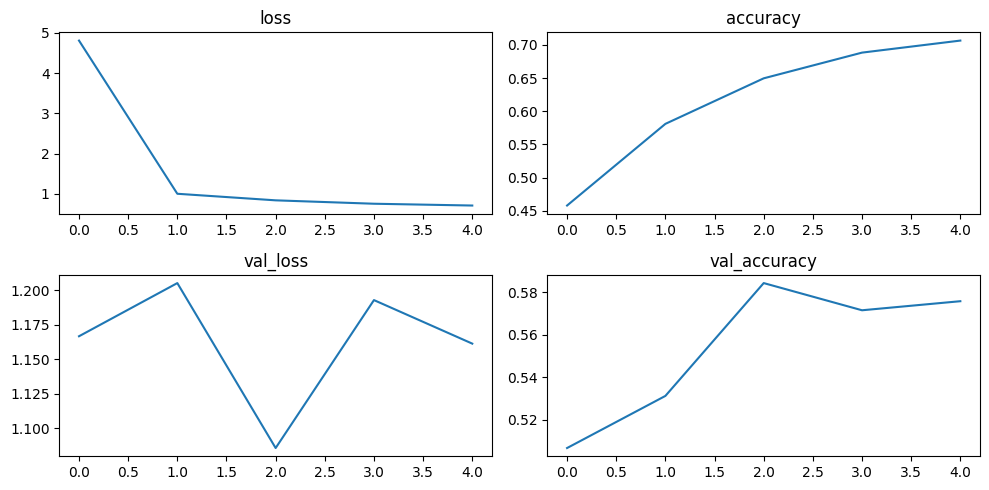

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(hist2.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(hist2.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(hist2.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(hist2.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()

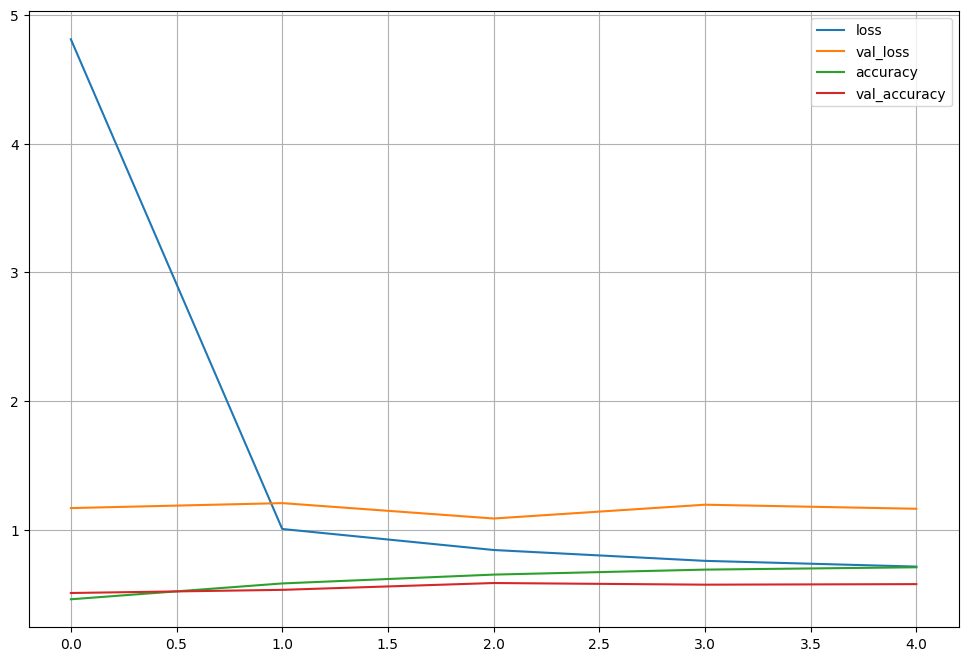

In [23]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12,8))

for each in plot_target:
    plt.plot(hist2.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [24]:
score2 = model2.evaluate(val_x)
score2

147/147 [==============================] - 33s 216ms/step - loss: 1.1613 - accuracy: 0.5757


[1.1613181829452515, 0.5756866335868835]